In [1]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import pandas as pd
from sklearn.preprocessing import scale,StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans

In [2]:
year = 2018

In [3]:
url = 'https://www.basketball-reference.com/leagues/NBA_{}_advanced.html'.format(year)
html = urlopen(url)
soup = BeautifulSoup(html,"lxml")

In [4]:
cols = [th.getText() for th in soup.findAll('tr',limit=3)[0].findAll('th')]
cols.remove('Rk')

In [5]:
rows = soup.findAll('tr')[1:]
dat = [[td.getText() for td in rows[i].findAll('td')] for i in (range(len(rows)))]

In [6]:
df = pd.DataFrame(dat,columns=cols)
df.head(5)

,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,FTr,...,,OWS,DWS,WS,WS/48,,OBPM,DBPM,BPM,VORP
0,Alex Abrines,SG,24,OKC,75,1134,9.0,.567,.759,.158,...,,1.3,1.0,2.2,.094,,-0.5,-1.7,-2.2,-0.1
1,Quincy Acy,PF,27,BRK,70,1359,8.2,.525,.800,.164,...,,-0.1,1.1,1.0,.036,,-2.0,-0.2,-2.2,-0.1
2,Steven Adams,C,24,OKC,76,2487,20.6,.630,.003,.403,...,,6.7,3.0,9.7,.187,,2.2,1.1,3.3,3.3
3,Bam Adebayo,C,20,MIA,69,1368,15.7,.570,.021,.526,...,,2.3,1.9,4.2,.148,,-1.6,1.8,0.2,0.8
4,Arron Afflalo,SG,32,ORL,53,682,5.8,.516,.432,.160,...,,-0.1,0.2,0.1,.009,,-4.1,-1.8,-5.8,-0.7


In [7]:
not_yet_num_cols = ['Age','G','MP','PER','TS%','3PAr','FTr',
                    'ORB%','DRB%','TRB%','AST%','STL%',
                    'BLK%','TOV%','USG%','OWS','DWS','WS',
                    'WS/48','OBPM','DBPM','BPM','VORP']

df = pd.concat([df[['Player','Pos','Tm',]], df[not_yet_num_cols].apply(pd.to_numeric, errors='ignore')], axis=1)

In [8]:
df = df[(df.G >= 50) & (df.MP >= 800) & (df.WS/48 > 0)]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 286 entries, 0 to 684
Data columns (total 26 columns):
Player    286 non-null object
Pos       286 non-null object
Tm        286 non-null object
Age       286 non-null float64
G         286 non-null float64
MP        286 non-null float64
PER       286 non-null float64
TS%       286 non-null float64
3PAr      286 non-null float64
FTr       286 non-null float64
ORB%      286 non-null float64
DRB%      286 non-null float64
TRB%      286 non-null float64
AST%      286 non-null float64
STL%      286 non-null float64
BLK%      286 non-null float64
TOV%      286 non-null float64
USG%      286 non-null float64
OWS       286 non-null float64
DWS       286 non-null float64
WS        286 non-null float64
WS/48     286 non-null float64
OBPM      286 non-null float64
DBPM      286 non-null float64
BPM       286 non-null float64
VORP      286 non-null float64
dtypes: float64(23), object(3)
memory usage: 60.3+ KB


In [10]:
df = df.reset_index()
df.to_csv('full_nba_data')

In [14]:
df_interesting_variables = ['TS%','3PAr','FTr','ORB%','DRB%','TRB%','AST%','STL%',
 'BLK%','TOV%','USG%','OWS','DWS','WS','WS/48','OBPM','DBPM','BPM', 'VORP']
df_k_means = df[df_interesting_variables]
df_k_means.to_csv('clustering_nba_data')

In [15]:
seed = 6
clusters = 10
scaler = StandardScaler()

In [16]:
kmeans = KMeans(n_clusters=clusters, random_state = seed)
pipeline = make_pipeline(scaler, kmeans)
pipeline.fit_transform(df_k_means)
labs = pipeline.predict(df_k_means)

In [17]:
results_df = pd.concat([df[['Player','Pos','Tm',]], df_k_means], axis=1)
results_df['label'] = labs.tolist()

In [18]:
results_df.head(5)

,Player,Pos,Tm,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,...,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,label
0,Alex Abrines,SG,OKC,0.567,0.759,0.158,2.5,8.9,5.6,3.4,...,12.7,1.3,1.0,2.2,0.094,-0.5,-1.7,-2.2,-0.1,5
1,Quincy Acy,PF,BRK,0.525,0.800,0.164,3.1,17.0,10.0,6.0,...,14.4,-0.1,1.1,1.0,0.036,-2.0,-0.2,-2.2,-0.1,0
2,Steven Adams,C,OKC,0.630,0.003,0.403,16.6,13.9,15.3,5.5,...,16.7,6.7,3.0,9.7,0.187,2.2,1.1,3.3,3.3,1
3,Bam Adebayo,C,MIA,0.570,0.021,0.526,9.7,21.6,15.6,11.0,...,15.9,2.3,1.9,4.2,0.148,-1.6,1.8,0.2,0.8,1
4,LaMarcus Aldridge,C,SAS,0.570,0.068,0.296,10.8,17.3,14.0,11.3,...,29.1,7.4,3.5,10.9,0.209,3.0,0.3,3.3,3.3,8


In [19]:
# results_dict = {}
# for i in list(range(0,clusters)):
#     results_dict["Cluster "+str(i)] = list(set(results_df[results_df.label==i]['Player']))

In [20]:
salary_url = 'https://www.basketball-reference.com/contracts/players.html'
salaries = pd.read_html(salary_url, header=1)[0]

In [21]:
salaries = salaries[salaries['Rk'] != 'Rk']
salaries = salaries[['Player', '2018-19', 'Guaranteed']]

In [22]:
for col in ['2018-19','Guaranteed']:
    salaries[col] = salaries[col].replace('[\$,]', '', regex=True).astype(float)
salaries.head()

,Player,2018-19,Guaranteed
0,Stephen Curry,37457154.0,166476240.0
1,Chris Paul,35654150.0,159730592.0
2,LeBron James,35654150.0,113310573.0
3,Russell Westbrook,35350000.0,158382000.0
4,Blake Griffin,31873932.0,102704892.0


In [23]:
salaries.to_csv('player_salaries')

In [24]:
combined_df = pd.merge(results_df, salaries, how='left', left_on=['Player'], right_on=['Player'])

In [25]:
combined_df = combined_df.fillna(0)
combined_df.to_csv('joined_nba_data')
combined_df.head()

,Player,Pos,Tm,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,...,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,label,2018-19,Guaranteed
0,Alex Abrines,SG,OKC,0.567,0.759,0.158,2.5,8.9,5.6,3.4,...,1.0,2.2,0.094,-0.5,-1.7,-2.2,-0.1,5,5455236.0,5455236.0
1,Quincy Acy,PF,BRK,0.525,0.800,0.164,3.1,17.0,10.0,6.0,...,1.1,1.0,0.036,-2.0,-0.2,-2.2,-0.1,0,0.0,0.0
2,Steven Adams,C,OKC,0.630,0.003,0.403,16.6,13.9,15.3,5.5,...,3.0,9.7,0.187,2.2,1.1,3.3,3.3,1,24157303.0,77528090.0
3,Bam Adebayo,C,MIA,0.570,0.021,0.526,9.7,21.6,15.6,11.0,...,1.9,4.2,0.148,-1.6,1.8,0.2,0.8,1,2955840.0,2955840.0
4,LaMarcus Aldridge,C,SAS,0.570,0.068,0.296,10.8,17.3,14.0,11.3,...,3.5,10.9,0.209,3.0,0.3,3.3,3.3,8,22347015.0,55347015.0


In [26]:
combined_df.groupby('label')[['2018-19']].median().reset_index(drop=True)

,2018-19
0,2405054.5
1,5337000.0
2,6978552.5
3,2526840.0
4,6300000.0
5,6635000.0
6,13764045.0
7,30715927.0
8,24157303.0
9,12000000.0


In [27]:
combined_df.groupby('label')[['Guaranteed']].median().reset_index(drop=True)

,Guaranteed
0,2405054.5
1,4449000.0
2,7222738.5
3,2526840.0
4,6300000.0
5,10750000.0
6,28928710.0
7,101358768.0
8,52527282.0
9,13750000.0


In [63]:
# median_list = combined_df.groupby('label')[['2018-19']].median().reset_index(drop=True)['2018-19'].tolist()
# dataframes = []
# for i in list(range(1,10)):
#     small_df = combined_df[combined_df['label'] == i]
#     small_df['median_salary'] = median_list[i]
#     dataframes.append(small_df)
# new_df = pd.concat(dataframes).reset_index(drop=True)

C:\Users\amola\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [66]:
# compare_df = new_df[['Player','Pos', 'Tm','label','2018-19','median_salary']] 
# compare_df.head()

,Player,Pos,Tm,label,2018-19,median_salary
0,Steven Adams,C,OKC,1,24157303.0,4449000.0
1,Bam Adebayo,C,MIA,1,2955840.0,4449000.0
2,Jarrett Allen,C,BRK,1,2034120.0,4449000.0
3,Jordan Bell,C,GSW,1,1378252.0,4449000.0
4,John Collins,PF,ATL,1,2299080.0,4449000.0


In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

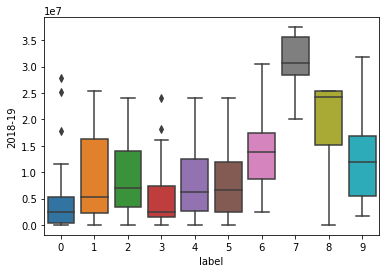

In [30]:
ax = sns.boxplot(x="label", y="2018-19",
            data=combined_df)
plt.show()

In [ ]:
# we will look to find the mos overpaid and underpaid players in each group
#underpaid: at or below 25% percentile
#overpaid: at or above 75% percentile 

In [31]:
analysis_df = combined_df[['Player','Pos','Tm','label','2018-19']]

In [33]:
analysis_df['label'].value_counts()

5    56
0    38
1    35
2    34
4    33
3    29
9    24
6    21
7    10
8     7
Name: label, dtype: int64

In [49]:
final_dict = {}
for clus in list(range(10)):
    small_df = analysis_df[analysis_df.label == clus]
    small_df.reset_index(drop=False,inplace=True)
    small_df.loc[:,'percentile'] = small_df['2018-19'].rank(pct=True)
    underpaid = small_df[small_df['percentile'] <= 0.25]['Player'].tolist()
    overpaid = small_df[small_df['percentile'] >= 0.75]['Player'].tolist()
    final_dict[clus] = [underpaid,overpaid]

C:\Users\amola\Anaconda3\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\amola\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [50]:
final_dict

{0: [['Quincy Acy',
   'Vince Carter',
   'Malcolm Delaney',
   'Josh Huestis',
   'Jarrett Jack',
   'Joe Johnson',
   'Patrick McCaw',
   'Jameer Nelson',
   'Isaiah Taylor',
   'Jason Terry'],
  ['Carmelo Anthony',
   'Alec Burks',
   'Shaun Livingston',
   'Ben McLemore',
   'Norman Powell',
   'Jonathon Simmons',
   'Garrett Temple',
   'Lance Thomas',
   'Evan Turner',
   'Andrew Wiggins']],
 1: [['Jarrett Allen',
   'Jordan Bell',
   'Alex Len',
   'Kevon Looney',
   'Greg Monroe',
   'Eric Moreland',
   'Daniel Theis',
   'David West'],
  ['Steven Adams',
   'Joel Embiid',
   'Derrick Favors',
   'Rudy Gobert',
   'Dwight Howard',
   'DeAndre Jordan',
   'Enes Kanter',
   'Jonas Valanciunas',
   'Hassan Whiteside']],
 2: [['Nemanja Bjelica',
   'Josh Hart',
   'Jonas Jerebko',
   'Maxi Kleber',
   'Kyle Kuzma',
   'Kelly Oubre',
   'Dario Saric',
   'Pascal Siakam'],
  ['Ryan Anderson',
   'Trevor Ariza',
   'DeMarre Carroll',
   'Aaron Gordon',
   'Tobias Harris',
   'Serge Ib

In [18]:
# salary_url = 'http://www.espn.com/nba/salaries/_/year/{}/page/{}/seasontype/4'
# url_list = [salary_url.format(year, i) for i in range(1,11)]

In [19]:
# salaries_dataframes = []
# for url in url_list:
#     salaries_dataframes.append(pd.read_html(url, header=0)[0])
# start_df = salaries_dataframes.pop()

In [20]:
# salaries = pd.concat(salaries_dataframes)                                         
# salaries = salaries[salaries.RK != 'RK']
# salaries.reset_index(drop=True, inplace=True)

In [21]:
# salaries['SALARY'] = salaries['SALARY'].replace('[\$,]', '', regex=True).astype(float)
# salaries['NAME'] = salaries['NAME'].str.split(',').str[0]

In [22]:
# salaries.drop(['RK','TEAM'],axis=1,inplace=True)

In [24]:
# combined_df = pd.merge(results_df, salaries, how='left', left_on=['Player'], right_on=['NAME'])
# combined_df.head()

,Player,Pos,Tm,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,...,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,label,NAME,SALARY
0,Alex Abrines,SG,OKC,0.567,0.759,0.158,2.5,8.9,5.6,3.4,...,1.0,2.2,0.094,-0.5,-1.7,-2.2,-0.1,5,Alex Abrines,5725000.0
1,Quincy Acy,PF,BRK,0.525,0.800,0.164,3.1,17.0,10.0,6.0,...,1.1,1.0,0.036,-2.0,-0.2,-2.2,-0.1,0,NaN,NaN
2,Steven Adams,C,OKC,0.630,0.003,0.403,16.6,13.9,15.3,5.5,...,3.0,9.7,0.187,2.2,1.1,3.3,3.3,1,Steven Adams,22471910.0
3,Bam Adebayo,C,MIA,0.570,0.021,0.526,9.7,21.6,15.6,11.0,...,1.9,4.2,0.148,-1.6,1.8,0.2,0.8,1,Bam Adebayo,2955840.0
4,LaMarcus Aldridge,C,SAS,0.570,0.068,0.296,10.8,17.3,14.0,11.3,...,3.5,10.9,0.209,3.0,0.3,3.3,3.3,8,LaMarcus Aldridge,21461010.0
